#**Mounting**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os

os.chdir('/content/drive/My Drive/Colab Notebooks/ML_class/RNN')
%pwd

# Generating names with a character-level RNN 

- We used a RNN to classify names into their language of origin. This time we’ll turn around and generate names from languages.

```python
> Russian R
Rovakov
 
> German G
Gerter
 
> Spanish S 
Sanera 

> Chinese H
Han

> Korean C
Cho 

``` 
- We are still hand-crafting a small RNN with a few linear layers. The big difference is instead of predicting a category after reading in all the letters of a name, we input a category and output one letter at a time. Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a “language model”.

- Recommended Reading: 
 - The Unreasonable Effectiveness of Recurrent Neural Networks shows a bunch of real life examples. (https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
 - Understanding LSTM Networks is about LSTMs specifically but also informative about RNNs in general. (https://colah.github.io/posts/2015-08-Understanding-LSTMs/)


#1. Preparing the data

- extract "data.zip" to the current directory.

In [0]:
import urllib

url, filename = ("https://download.pytorch.org/tutorial/data.zip", "data.zip")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

!unzip data.zip


Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  



- There are a bunch of plain text files data/names/[Language].txt with a name per line. We split lines into an array, convert Unicode to ASCII, and end up with a dictionary {language: [names ...]}.

In [0]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories) 
if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')
    
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Japanese', 'Polish', 'French', 'Irish', 'Italian', 'Scottish', 'Czech', 'Spanish', 'Greek', 'Chinese', 'Arabic', 'Dutch', 'Korean', 'English', 'German', 'Vietnamese', 'Russian', 'Portuguese']
O'Neal


#2. Creating the Network 

- This network extends RNN with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

- We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

- We will add a second linear layer o2o (after combining hidden and output) to give it more muscle to work with. There’s also a dropout layer, which randomly zeros parts of its input with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we’re using it towards the end of the network to purposely add some chaos and increase sampling variety.

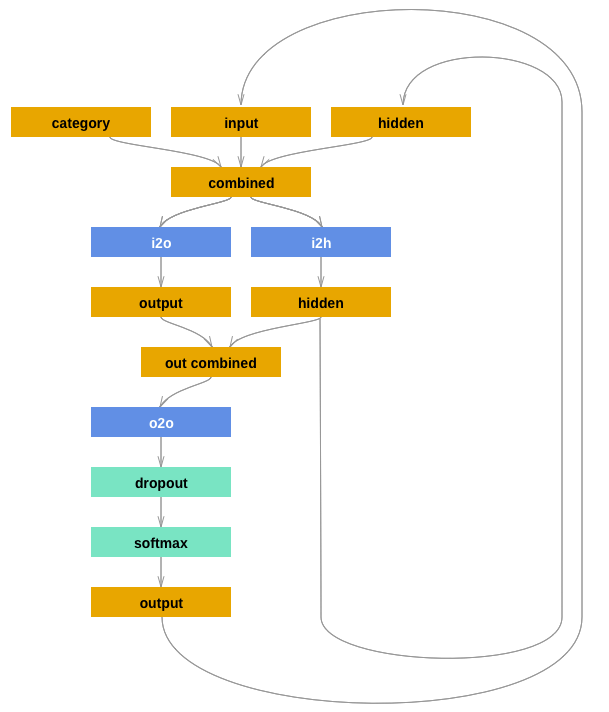

**Exercise**: 
- Implement the NNModel class below to build the above RNN model. You should use the functions above.
 - **torch.nn.Linear(in_features, out_features, bias=True)** : Applies a linear transformation to the incoming data.
   - For more details: https://pytorch.org/docs/master/generated/torch.nn.Linear.html
  - **torch.cat(tensors, dim=0, out=None)** : Concatenates the given sequence of seq tensors in the given dimension. All tensors must either have the same shape (except in the concatenating dimension) or be empty.
    - For more details: https://pytorch.org/docs/stable/torch.html


In [0]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        ### START CODE HERE ###
        # Define the Linear layer(nn.Linear) with (in_features:n_categories + input_size + hidden_size, out_features: hidden_size) 
        self.i2h = None 
        # Define the Linear layer(nn.Linear) with (in_features:n_categories + input_size + hidden_size, out_features: output_size) 
        self.i2o =  None
        # Define the Linear layer(nn.Linear) with (in_features:hidden_size + output_size, out_features: output_size)  
        self.o2o =  None
        ### END CODE HERE ### 

        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        ### START CODE HERE ###
        # Load input to hidden layer(i2h)   
        hidden = None
        # Load input to output layer(i2o) 
        output = None
        # Concatenate i2o and i2h (torch.cat) 
        output_combined = None
        # Load input to output layer(o2o)
        output = None
        ### END CODE HERE ###  
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# 3. Training

## 3.1. Preparing for training

- First of all, helper functions to get random pairs of (category, line):



In [0]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

- For each timestep (that is, for each letter in a training word) the inputs of the network will be (category, current letter, hidden state) and the outputs will be (next letter, next hidden state). So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

- Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).

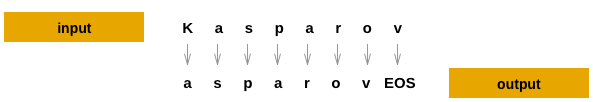

- The category tensor is a **one-hot tensor** of size <1 x n_categories>. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [0]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

- For convenience during training we’ll make a **randomTrainingExample function** that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [0]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

##3.2. Training the Network

- In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

- The magic of autograd allows you to simply sum these losses at each step and call backward at the end. 

**Exercise**: Complete the function below.   
- Define the cost function for the classficiation with multiple classes. 
- initialize the gradient of the RNN   
- compute the backward propagation

**Hint** 
- Initialize the gradient of model   
        model_name.zero_grad() 
- Define the cost function
 - **torch.nn.NLLLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')** :The negative log likelihood loss. It is useful to train a classification problem with C classes.
   - For more details: https://pytorch.org/docs/stable/nn.html

- Compute the backward propagation   
        loss.backward() 

In [0]:
# START CODE 
# Define Loss function as the name of criterion 
criterion = None
# END CODE 

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    # START CODE 
    # Initialize the gradient of rnn   
    None
    # END CODE 

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # START CODE 
    # Update the weight parameter values using back propagation    
    None
    # END CODE 

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

- To keep track of how long training takes I am adding a timeSince(timestamp) function which returns a human readable string:

In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

- Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every print_every examples, and keeping store of an average loss per plot_every examples in all_losses for plotting later.

In [0]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 20s (5000 5%) 2.7370
0m 39s (10000 10%) 2.1940
0m 58s (15000 15%) 2.7956
1m 17s (20000 20%) 2.6875
1m 36s (25000 25%) 1.9744
1m 55s (30000 30%) 2.4637
2m 15s (35000 35%) 2.8730
2m 34s (40000 40%) 2.4105
2m 54s (45000 45%) 2.6359
3m 13s (50000 50%) 2.5815
3m 33s (55000 55%) 1.1368
3m 52s (60000 60%) 2.2683
4m 12s (65000 65%) 2.7109
4m 32s (70000 70%) 2.9966
4m 52s (75000 75%) 1.7630
5m 12s (80000 80%) 2.3575
5m 31s (85000 85%) 1.9416
5m 52s (90000 90%) 3.0294
6m 11s (95000 95%) 2.9307
6m 31s (100000 100%) 2.5934


##3.3. Plotting the Losses

- Plotting the historical loss from all_losses shows the network learning:




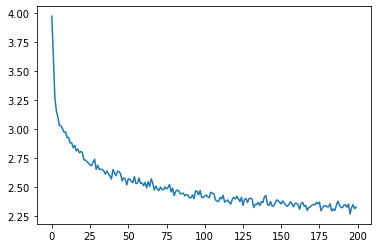

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

#4. Sampling the Network

- To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.
 - Create tensors for input category, starting letter, and empty hidden state
 - Create a string output_name with the starting letter
 - Up to a maximum output length,
   - Feed the current letter to the network
   - Get the next letter from highest output, and next hidden state
   - If the letter is EOS, stop here
 - If a regular letter, add to output_name and continue
Return the final name

- Note 
 - Rather than having to give it a starting letter, another strategy would have been to include a “start of string” token in training and have the network choose its own starting letter.



In [0]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'R')

samples('German', 'G')

samples('Spanish', 'S')

samples('Chinese', 'H')

samples('Korean', 'C')

Rovakov
Gerter
Sanera
Han
Cho


# 4. Reference

- NLP From Scratch: Generating Names with a Character-Level RNN
 - https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html